# 1 Imports and config

In [1]:
ff_rob_using = True
max_sentence_size = 512

In [2]:
!pip install transformers
!pip install torchmetrics
!pip install scikit-optimize

  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl (868 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)


In [3]:
import os
import time

import pandas as pd
import numpy as np

import hashlib
import json
import shutil
import torch
import tqdm
import torchmetrics
import math
import pickle
import skopt

import time
import sklearn.neural_network
import sklearn.ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import BaseEstimator, ClassifierMixin

import io, re
import nltk
from nltk.corpus import wordnet as wn
from itertools import chain

In [4]:
# to import files from googledrive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
sample_size_dir = 'drive/MyDrive/Sample size for NLP'
assert(os.path.exists(sample_size_dir))

Mounted at /content/drive/


In [5]:
def time_code():
    def decorate(func):
        def call(*args, **kwargs):
            print('Entered function %s' % func.__name__)
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            func_time = end - start
            print('Exiting function %s - took %.2f seconds' % (func.__name__, func_time))
            return result
        return call
    return decorate

In [6]:
def load_results(file_path):
  with open(file_path, 'rb') as f:
    return pickle.load(f)

def save_results(results, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [7]:
def mean_sd_str(input_list: list, precision: int = 2, remove_nans: bool = False):
    mean, sd = mean_and_standard_deviation(input_list, remove_nans=remove_nans)
    return ('%f ± %f') % (round(mean, precision), round(sd, precision))


def mean_and_standard_deviation(input_list, remove_nans=False):
    if remove_nans:
        input_list = [i for i in input_list if not math.isnan(i)]

    if len(input_list) == 1:
        return input_list[0], 0

    mean = sum(input_list) / len(input_list)

    variance = (sum([(x - mean) ** 2 for x in input_list])) / (len(input_list) - 1)

    standard_deviation = variance ** (1 / 2)

    return mean, standard_deviation

# 2 Embedding and other functions

In [8]:
@time_code()
def get_data_for_classifier(diagnosis: str):
  if diagnosis == 'original':
    path = os.path.join(sample_size_dir, 'Sample_Size_Saniya')
    return pd.read_csv(path+'/12k_data_for_classifier.csv')
  else:
    path = os.path.join(sample_size_dir, 'data_Kai', 'new_6000')

    positive_samples = pd.read_csv(os.path.join(path, '%s_merged_report_6000_with.csv' % diagnosis))
    positive_samples['label'] = 1

    negative_samples = pd.read_csv(os.path.join(path, '%s_merged_report_6000_without.csv' % diagnosis))
    negative_samples['label'] = 0

    df = pd.concat([positive_samples, negative_samples])
    df = df.rename(columns={'TEXT': 'text'})
    return df


In [9]:
from transformers import BertTokenizer, LongformerTokenizer
@time_code()
def get_tokenizer(pretrained_string: str, padding_side :str, truncate_side :str, do_lower_case: bool):
# Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained(pretrained_string,
                                            padding_side=padding_side,
                                            do_lower_case=do_lower_case,
                                            truncation_side=truncate_side) #bert-base-uncased
  return tokenizer

In [10]:
from transformers import  BertModel, LongformerModel


class BertEmbeddingCache:

  def __init__(self, model_str, cache_folder, padding_side, truncate_side, max_sentence_size, do_lower_case, device, split_input=False, max_pooling_layers=1):
    """
    Cache for Pooled outputs of Bert model
    @param model_str - the hugging face model bert model to load
    @param cache_folder - The location to save the cache file too
    @param padding_size - "left", "right" which side to add padding
    @param tuncate_side - "left", "right" which side to truncate
    @param max_sentence_size - The size of the bert model
    @param do_lowewr_case - param to pass to bert model
    @param device - The pytorch device to return vectors on
    @param split_input - If true, input will be split and fed through model
    and then concatinated and returned.
    e.g. BERT max tokens is 512, this switch will split an input into chunks
    pass each chunk through the model and then combine them to return them
    """
    self.device = device
    self._tokenizer = get_tokenizer(model_str, padding_side, truncate_side, do_lower_case)
    self._model = BertModel.from_pretrained(model_str).to(device)
    self.config_dict = {
        'model_str':model_str,
        'padding_side':padding_side,
        'truncate_side':truncate_side,
        'max_sentence_size':max_sentence_size,
        'do_lower_case':do_lower_case
    }
    # we put these in the config dict only if they are not deatult values
    # for backwards compatability when these params did not exist
    if split_input:
      self.config_dict['split_input'] = split_input
    if max_pooling_layers != 1:
      self.config_dict['max_pooling_layers'] = max_pooling_layers

    self.split_input = split_input
    self.max_pooling_layers = max_pooling_layers
    config_hash = hashlib.md5(json.dumps(self.config_dict, sort_keys=True).encode('utf-8')).hexdigest()

    self._output_folder = os.path.join(cache_folder, config_hash)
    #shutil.rmtree(self._output_folder) # TODO
    self._look_up_file = os.path.join(self._output_folder, 'lookup.pkl')
    self._init_cache_folder()

    self.model_str = model_str
    self.max_sentence_size = max_sentence_size
    self.cache = self.load_lookup_table()
    self.save_needed = False
    self.empty_pool = self.forward_no_cache('')

  def get_max_tokens(self, data):
    max_len = 0
    with torch.no_grad():
      for sentence in data.text.values:
        encoded_dict = self._tokenizer.encode_plus(
                      sentence,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      #max_length = self.max_sentence_size,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                ).to(self.device)
        max_len = max(max_len, encoded_dict['input_ids'].shape[1])
    self.max_token_len = max_len
    return max_len

  def _init_cache_folder(self):
    if not os.path.exists(self._output_folder):
      os.makedirs(self._output_folder)

    if not os.path.exists(self._look_up_file):
      self.save_lookup_table({})

    config_file = os.path.join(self._output_folder, 'config.json')
    if not os.path.exists(config_file):
      with open(config_file, 'w') as f:
        json.dump(self.config_dict, f)

    sentence_embeddings_folder = os.path.join(self._output_folder, 'sentence_embeddings')
    if not os.path.exists(sentence_embeddings_folder):
      os.makedirs(sentence_embeddings_folder)


  def load_lookup_table(self):
    with open(self._look_up_file, 'rb') as f:
      return torch.load(f, map_location=self.device)

  def save_lookup_table(self, table):
    print("saving")
    with open(self._look_up_file + '.tmp', 'wb') as f:
      torch.save(table, f)

    if os.path.exists(self._look_up_file):
      shutil.move(self._look_up_file, self._look_up_file + '.tmp' + '.tmp')
    shutil.move(self._look_up_file + '.tmp', self._look_up_file)
    if os.path.exists(self._look_up_file + '.tmp' + '.tmp'):
      os.remove(self._look_up_file + '.tmp' + '.tmp')
    self.save_needed = False

  def hash_sentence(self, sent):
    return hashlib.md5(sent.encode('utf-8')).hexdigest()

  def forward_no_cache_split(self, sentence):
    words = sentence.split(' ')
    length = len(words)

    pooling_layers = []
    with torch.no_grad():
      encoded_dict = self._tokenizer.encode_plus(
                      sentence,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = self.max_token_len,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                ).to(self.device)

      #for pooling_layer in range(self.max_pooling_layers):
      for pooling_layer in range((encoded_dict['input_ids'].shape[1] // self.max_sentence_size) + 1):
        tokens = encoded_dict['input_ids'][:, (pooling_layer)*self.max_sentence_size:(pooling_layer +1)*self.max_sentence_size]
        try:
          output = self._model(tokens, return_dict = True)[1].detach()
        except:
          print(encoded_dict['input_ids'].shape)
        pooling_layers.append(output)

      while len(pooling_layers) < self.max_pooling_layers:
        pooling_layers.append(self.empty_pool)

    to_return = torch.concat(pooling_layers, 1)
    return to_return

  def forward_no_cache(self, sentence):
    with torch.no_grad():
      encoded_dict = self._tokenizer.encode_plus(
                      sentence,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      max_length = self.max_sentence_size,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                ).to(self.device)

      # [1] at the end it us taking the pooled layer of the bert model
      output = self._model(encoded_dict['input_ids'], attention_mask=encoded_dict ['attention_mask'], return_dict = True)[1].detach()
    return output

  def forward(self, sentence):

    key = self.hash_sentence(sentence)
    # we make sure we not only have the key but that we have it
    if key in self.cache:
      return self.cache[key].to(device)

    # if we are splitting
    if self.split_input:
      output = self.forward_no_cache_split(sentence)
    else: # otherwise we just feed input into the model
      output = self.forward_no_cache(sentence)


    self.cache[key] =  output.detach()

    self.save_needed = True

    return output.detach()


In [11]:
def get_max_length_for_dataset(dataset):
  lengths = list(map(lambda x: len(x.split(' ')), data.text.values))

  return max(lengths)

# 3 Manifests

In [ ]:
###############################################
# Get the length of sentences in dataset      #
###############################################



for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  data = get_data_for_classifier(dataset)

  lengths = list(map(lambda x: len(x.split(' ')), data.text.values))

  print("dataset %s length: %s 512 ratio %s max %s" % (dataset, mean_sd_str(lengths), 512 / (sum(lengths) / len(lengths)), max(lengths)))


Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.21 seconds
dataset original length: 266.610000 ± 338.730000 512 ratio 1.9204128887710858
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.27 seconds
dataset 53081 length: 1486.720000 ± 715.880000 512 ratio 0.3443815693979309
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.33 seconds
dataset 51881 length: 1552.070000 ± 803.940000 512 ratio 0.329881993092881
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.22 seconds
dataset 42731 length: 1484.440000 ± 717.790000 512 ratio 0.34491171573705737
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.23 seconds
dataset 41401 length: 1432.570000 ± 692.070000 512 ratio 0.35740071950163077
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.24 seconds
datas

In [ ]:
def get_max_tokens(data):

  max_len = 0
  with torch.no_grad():
    for sentence in data.text.values:
      encoded_dict = self._tokenizer.encode_plus(
                      sentence,                      # Sentence to encode.
                      add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                      #max_length = self.max_sentence_size,           # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                ).to(self.device)
      max_len = max(max_len, encoded_dict['input_ids'].shape[1])

In [13]:
################################################################################
# Manifest: Testing all models/datasets on the larget amount of train in a 10 fold      #
# we test different models with default configurations                         #
################################################################################
import sklearn.neural_network
import sklearn.ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

#results_file = os.path.join(sample_size_dir, 'program_data', 'results_right_02f5f818-e627-4667-a66e-dff5ba4227be.pkl') #uuid for the left padding and truncation 775573dc-4e77-4529-92da-26710502ad50.pkl')
results_file = os.path.join(sample_size_dir, 'program_data', 'results_split_02f5f818-e627-4667-a66e-dff5ba4227be.pkl') #uuid for the left padding and truncation 775573dc-4e77-4529-92da-26710502ad50.pkl')

save_results({}, results_file) # TODO

if not os.path.exists(results_file):
  save_results({}, results_file)

results = load_results(results_file)

models_to_run = [('mlp', sklearn.neural_network.MLPClassifier), ('random_tree', sklearn.ensemble.RandomForestClassifier),]#, ('aga_boost', sklearn.ensemble.AdaBoostClassifier)]

for dataset in ['53081',]:#['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:

  if dataset not in results:
    results[dataset] = {}
  print("running for dataset: %s" % dataset)

  data = get_data_for_classifier(dataset)

  embeddings_cache = BertEmbeddingCache("cambridgeltl/SapBERT-from-PubMedBERT-fulltext", #
                                        os.path.join(sample_size_dir, 'program_data'),
                                        'right',
                                        'right',
                                        512,
                                        True,
                                        device,
                                        split_input=True,
                                        max_pooling_layers=1 + int(get_max_length_for_dataset(dataset)/ 512)
                                        )
  embeddings_cache.get_max_tokens(data)

  print(1 + int(get_max_length_for_dataset(dataset)/ 512))
  xs = []
  ys = []
  for idx, (sentence, label) in enumerate(tqdm.tqdm(list(zip(data.text.values, data.label.values)))):
    xs.append(embeddings_cache.forward(sentence))
    ys.append(label)

    # don't save the cache all the time but every 1000 samples
    if idx % 100 == 0 and embeddings_cache.save_needed:
      embeddings_cache.save_lookup_table(embeddings_cache.cache)

  # at the end save the cache if needed
  if embeddings_cache.save_needed:
    embeddings_cache.save_lookup_table(embeddings_cache.cache)

  x = torch.concat(xs).detach().cpu().numpy()
  y = np.stack(ys)


  accuracy_function = torchmetrics.classification.BinaryAccuracy()
  f1_function = torchmetrics.classification.BinaryF1Score()
  tnr_function = torchmetrics.classification.BinarySpecificity()
  tpr_function = torchmetrics.classification.BinaryRecall()
  mcc_function = torchmetrics.classification.BinaryMatthewsCorrCoef()

  for model_str, model_class in models_to_run:

    if model_str not in results[dataset]:
      results[dataset][model_str] = {}
    skf = StratifiedKFold(10, random_state=1, shuffle=True)

    if dataset in results and \
        model_str in results[dataset] and \
        'accuracy' in results[dataset][model_str]:
      accs = results[dataset][model_str]['accuracy']
      f1s = results[dataset][model_str]['f1s']
      tnrs = results[dataset][model_str]['tnrs']
      tprs = results[dataset][model_str]['tprs']
      mccs = results[dataset][model_str]['mccs']
      gmeans = results[dataset][model_str]['gmeans']
    else:
      accs = []
      f1s = []
      tnrs = []
      tprs = []
      mccs = []
      gmeans = []

    for idx, (train_indexes, test_indexes) in enumerate(skf.split(x, y)):
      if len(accs) > idx:
        print("skipping cross fold %d as we have results already" % idx)
      else:
        print("Running cross fold index: %d" % idx)
        x_train, x_test, y_train, y_test = x[train_indexes], x[test_indexes], y[train_indexes], y[test_indexes]

        model = model_class()
        model.fit(x_train, y_train)
        predictions = model.predict_proba(x_test)# TODO - should be test
        predictions = predictions.argmax(axis=1) # we take the max probability

        predictions = torch.tensor(predictions)
        y_test = torch.tensor(y_test)# TODO - should be test
        accs.append(accuracy_function(predictions, y_test).item())
        f1s.append(f1_function(predictions, y_test).item())
        tnrs.append(tnr_function(predictions, y_test).item())
        tprs.append(tpr_function(predictions, y_test).item())
        mccs.append(mcc_function(predictions, y_test).item())
        gmeans.append(math.sqrt(tnrs[-1] * tprs[-1]))
        results[dataset][model_str] = {
            'accuracy': accs,
            'f1s': f1s,
            'tnrs': tnrs,
            'tprs': tprs,
            'mccs': mccs,
            'gmeans': gmeans,
        }
      print('accuracy: %.2f' % accs[idx])
      print('f1: %.2f' % f1s[idx])
      print('tnr: %.2f' % tnrs[idx])
      print('tpr: %.2f' % tprs[idx])
      print('mcc: %.2f' % mccs[idx])
      print('gmean: %.2f' % gmeans[idx])
      save_results(results, results_file)

    print('Accuracy: %s ' % mean_sd_str(accs))
    print('F1: %s ' % mean_sd_str(f1s))
    print('TNR: %s ' % mean_sd_str(tnrs))
    print('TPR: %s ' % mean_sd_str(tprs))
    print('G-MEAN: %s ' % mean_sd_str(gmeans))
    print('MCC: %s ' % mean_sd_str(mccs))


running for dataset: 53081
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 6.11 seconds
Entered function get_tokenizer
Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

Exiting function get_tokenizer - took 3.18 seconds


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
################################################################################
# Manifest: Training for different amounts of training data                    #
# we test different models with default configurations                         #
################################################################################
import sklearn.neural_network
import sklearn.ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
CROSS_FOLDS = 10


results_file = os.path.join(sample_size_dir, 'program_data', 'results_random_forest_diff_amounts.pkl') #uuid for the left padding and truncation 775573dc-4e77-4529-92da-26710502ad50.pkl')

if not os.path.exists(results_file):
  save_results({}, results_file)

results = load_results(results_file)

models_to_run = [('random_tree', sklearn.ensemble.RandomForestClassifier)]#('aga_boost', sklearn.ensemble.AdaBoostClassifier) ('mlp', sklearn.neural_network.MLPClassifier)]#, ('random_tree', sklearn.ensemble.RandomForestClassifier), ]

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  if dataset not in results:
    results[dataset] = {}

  print("running for dataset: %s" % dataset)

  data = get_data_for_classifier(dataset)

  embeddings_cache = BertEmbeddingCache('cambridgeltl/SapBERT-from-PubMedBERT-fulltext', os.path.join(sample_size_dir, 'program_data'), 'right', 'right', 512, True, device)

  #embeddings_cache.save_lookup_table(embeddings_cache.cache)

  xs = []
  ys = []
  for idx, (sentence, label) in enumerate(tqdm.tqdm(list(zip(data.text.values, data.label.values)))):

    xs.append(embeddings_cache.forward(sentence))
    ys.append(label)

    if idx % 1000 == 0 and embeddings_cache.save_needed:
      embeddings_cache.save_lookup_table(embeddings_cache.cache)

  if embeddings_cache.save_needed:
      embeddings_cache.save_lookup_table(embeddings_cache.cache)

  x = torch.concat(xs).detach().cpu().numpy()
  y = np.stack(ys)


  accuracy_function = torchmetrics.classification.BinaryAccuracy()
  f1_function = torchmetrics.classification.BinaryF1Score()
  tnr_function = torchmetrics.classification.BinarySpecificity()
  tpr_function = torchmetrics.classification.BinaryRecall()
  mcc_function = torchmetrics.classification.BinaryMatthewsCorrCoef()

  for model_str, model_class in models_to_run:

    if model_str not in results[dataset]:
      results[dataset][model_str] = {}

    for train_size in [int((12000*0.1) * i/20) for i in range(1, 21)] + [int((12000*0.9) * i/10) for i in range(1, 11)]:

      if train_size not in results[dataset][model_str]:
        results[dataset][model_str][train_size] = {
              'accuracy': [],
              'f1s': [],
              'tnrs': [],
              'tprs': [],
              'mccs': [],
              'gmeans': [],
          }

      skf = StratifiedKFold(CROSS_FOLDS, random_state=1, shuffle=True)

      accs = results[dataset][model_str][train_size]['accuracy']
      f1s =  results[dataset][model_str][train_size]['f1s']
      tnrs =  results[dataset][model_str][train_size]['tnrs']
      tprs =  results[dataset][model_str][train_size]['tprs']
      mccs =  results[dataset][model_str][train_size]['mccs']
      gmeans =  results[dataset][model_str][train_size]['gmeans']

      for idx, (train_indexes, test_indexes) in enumerate(skf.split(x, y)):

        if len(results[dataset][model_str][train_size]['accuracy']) > idx: # skip ones we have results for
          continue

        # Need to keep the balance 50-50 in the train dataset
        # so iterate over train indexes, pick first positive and negative half
        single_class_size = train_size // 2
        positives = []
        negatives = []
        for train_index in train_indexes:
          if y[train_index] == 1 and len(positives) < single_class_size:
            positives.append(train_index)
          elif y[train_index] == 0 and len(negatives) < single_class_size:
            negatives.append(train_index)
        train_indexes = positives + negatives

        print("Running dataset %s model %s train_size %d, cross fold index: %d" % (dataset, model_str, train_size, idx))
        x_train, x_test, y_train, y_test = x[train_indexes], x[test_indexes], y[train_indexes], y[test_indexes]

        model = model_class()
        model.fit(x_train, y_train)
        predictions = model.predict_proba(x_test)
        predictions = predictions.argmax(axis=1) # we take the max probability

        predictions = torch.tensor(predictions)
        y_test = torch.tensor(y_test)
        accs.append(accuracy_function(predictions, y_test).item())
        f1s.append(f1_function(predictions, y_test).item())
        tnrs.append(tnr_function(predictions, y_test).item())
        tprs.append(tpr_function(predictions, y_test).item())
        mccs.append(mcc_function(predictions, y_test).item())
        gmeans.append(math.sqrt(tnrs[-1] * tprs[-1]))
        results[dataset][model_str][train_size] = {
            'accuracy': accs,
            'f1s': f1s,
            'tnrs': tnrs,
            'tprs': tprs,
            'mccs': mccs,
            'gmeans': gmeans,
        }
        save_results(results, results_file)

      print('Accuracy: %s ' % mean_sd_str(accs))
      print('F1: %s ' % mean_sd_str(f1s))
      print('TNR: %s ' % mean_sd_str(tnrs))
      print('TPR: %s ' % mean_sd_str(tprs))
      print('G-MEAN: %s ' % mean_sd_str(gmeans))
      print('MCC: %s ' % mean_sd_str(mccs))


running for dataset: original
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.25 seconds
Entered function get_tokenizer
Loading BERT tokenizer...
Exiting function get_tokenizer - took 0.16 seconds


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 160319.95it/s]


Running dataset original model random_tree train_size 60, cross fold index: 0
Running dataset original model random_tree train_size 60, cross fold index: 1
Running dataset original model random_tree train_size 60, cross fold index: 2
Running dataset original model random_tree train_size 60, cross fold index: 3
Running dataset original model random_tree train_size 60, cross fold index: 4
Running dataset original model random_tree train_size 60, cross fold index: 5
Running dataset original model random_tree train_size 60, cross fold index: 6
Running dataset original model random_tree train_size 60, cross fold index: 7
Running dataset original model random_tree train_size 60, cross fold index: 8
Running dataset original model random_tree train_size 60, cross fold index: 9
Accuracy: 0.590000 ± 0.020000 
F1: 0.570000 ± 0.040000 
TNR: 0.640000 ± 0.040000 
TPR: 0.550000 ± 0.060000 
G-MEAN: 0.590000 ± 0.020000 
MCC: 0.190000 ± 0.040000 
Running dataset original model random_tree train_size 120

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 38388.55it/s]


Running dataset 53081 model random_tree train_size 60, cross fold index: 0
Running dataset 53081 model random_tree train_size 60, cross fold index: 1
Running dataset 53081 model random_tree train_size 60, cross fold index: 2
Running dataset 53081 model random_tree train_size 60, cross fold index: 3
Running dataset 53081 model random_tree train_size 60, cross fold index: 4
Running dataset 53081 model random_tree train_size 60, cross fold index: 5
Running dataset 53081 model random_tree train_size 60, cross fold index: 6
Running dataset 53081 model random_tree train_size 60, cross fold index: 7
Running dataset 53081 model random_tree train_size 60, cross fold index: 8
Running dataset 53081 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.550000 ± 0.010000 
F1: 0.560000 ± 0.020000 
TNR: 0.550000 ± 0.040000 
TPR: 0.560000 ± 0.030000 
G-MEAN: 0.550000 ± 0.010000 
MCC: 0.110000 ± 0.030000 
Running dataset 53081 model random_tree train_size 120, cross fold index: 0
Running dat

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 33032.06it/s]


Running dataset 51881 model random_tree train_size 60, cross fold index: 0
Running dataset 51881 model random_tree train_size 60, cross fold index: 1
Running dataset 51881 model random_tree train_size 60, cross fold index: 2
Running dataset 51881 model random_tree train_size 60, cross fold index: 3
Running dataset 51881 model random_tree train_size 60, cross fold index: 4
Running dataset 51881 model random_tree train_size 60, cross fold index: 5
Running dataset 51881 model random_tree train_size 60, cross fold index: 6
Running dataset 51881 model random_tree train_size 60, cross fold index: 7
Running dataset 51881 model random_tree train_size 60, cross fold index: 8
Running dataset 51881 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.620000 ± 0.020000 
F1: 0.590000 ± 0.020000 
TNR: 0.700000 ± 0.040000 
TPR: 0.540000 ± 0.030000 
G-MEAN: 0.620000 ± 0.020000 
MCC: 0.250000 ± 0.040000 
Running dataset 51881 model random_tree train_size 120, cross fold index: 0
Running dat

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 30280.89it/s]


Running dataset 42731 model random_tree train_size 60, cross fold index: 0
Running dataset 42731 model random_tree train_size 60, cross fold index: 1
Running dataset 42731 model random_tree train_size 60, cross fold index: 2
Running dataset 42731 model random_tree train_size 60, cross fold index: 3
Running dataset 42731 model random_tree train_size 60, cross fold index: 4
Running dataset 42731 model random_tree train_size 60, cross fold index: 5
Running dataset 42731 model random_tree train_size 60, cross fold index: 6
Running dataset 42731 model random_tree train_size 60, cross fold index: 7
Running dataset 42731 model random_tree train_size 60, cross fold index: 8
Running dataset 42731 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.620000 ± 0.010000 
F1: 0.630000 ± 0.020000 
TNR: 0.600000 ± 0.040000 
TPR: 0.650000 ± 0.040000 
G-MEAN: 0.620000 ± 0.010000 
MCC: 0.250000 ± 0.030000 
Running dataset 42731 model random_tree train_size 120, cross fold index: 0
Running dat

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 31088.44it/s]


Running dataset 41401 model random_tree train_size 60, cross fold index: 0
Running dataset 41401 model random_tree train_size 60, cross fold index: 1
Running dataset 41401 model random_tree train_size 60, cross fold index: 2
Running dataset 41401 model random_tree train_size 60, cross fold index: 3
Running dataset 41401 model random_tree train_size 60, cross fold index: 4
Running dataset 41401 model random_tree train_size 60, cross fold index: 5
Running dataset 41401 model random_tree train_size 60, cross fold index: 6
Running dataset 41401 model random_tree train_size 60, cross fold index: 7
Running dataset 41401 model random_tree train_size 60, cross fold index: 8
Running dataset 41401 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.770000 ± 0.010000 
F1: 0.770000 ± 0.010000 
TNR: 0.780000 ± 0.030000 
TPR: 0.760000 ± 0.030000 
G-MEAN: 0.770000 ± 0.010000 
MCC: 0.540000 ± 0.030000 
Running dataset 41401 model random_tree train_size 120, cross fold index: 0
Running dat

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 32433.05it/s]


Running dataset 25000 model random_tree train_size 60, cross fold index: 0
Running dataset 25000 model random_tree train_size 60, cross fold index: 1
Running dataset 25000 model random_tree train_size 60, cross fold index: 2
Running dataset 25000 model random_tree train_size 60, cross fold index: 3
Running dataset 25000 model random_tree train_size 60, cross fold index: 4
Running dataset 25000 model random_tree train_size 60, cross fold index: 5
Running dataset 25000 model random_tree train_size 60, cross fold index: 6
Running dataset 25000 model random_tree train_size 60, cross fold index: 7
Running dataset 25000 model random_tree train_size 60, cross fold index: 8
Running dataset 25000 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.540000 ± 0.010000 
F1: 0.550000 ± 0.040000 
TNR: 0.520000 ± 0.050000 
TPR: 0.560000 ± 0.070000 
G-MEAN: 0.540000 ± 0.010000 
MCC: 0.080000 ± 0.030000 
Running dataset 25000 model random_tree train_size 120, cross fold index: 0
Running dat

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 33188.54it/s]


Running dataset 5990 model random_tree train_size 60, cross fold index: 0
Running dataset 5990 model random_tree train_size 60, cross fold index: 1
Running dataset 5990 model random_tree train_size 60, cross fold index: 2
Running dataset 5990 model random_tree train_size 60, cross fold index: 3
Running dataset 5990 model random_tree train_size 60, cross fold index: 4
Running dataset 5990 model random_tree train_size 60, cross fold index: 5
Running dataset 5990 model random_tree train_size 60, cross fold index: 6
Running dataset 5990 model random_tree train_size 60, cross fold index: 7
Running dataset 5990 model random_tree train_size 60, cross fold index: 8
Running dataset 5990 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.580000 ± 0.010000 
F1: 0.580000 ± 0.030000 
TNR: 0.600000 ± 0.040000 
TPR: 0.570000 ± 0.050000 
G-MEAN: 0.580000 ± 0.010000 
MCC: 0.170000 ± 0.020000 
Running dataset 5990 model random_tree train_size 120, cross fold index: 0
Running dataset 5990 m

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 30232.69it/s]


Running dataset 5849 model random_tree train_size 60, cross fold index: 0
Running dataset 5849 model random_tree train_size 60, cross fold index: 1
Running dataset 5849 model random_tree train_size 60, cross fold index: 2
Running dataset 5849 model random_tree train_size 60, cross fold index: 3
Running dataset 5849 model random_tree train_size 60, cross fold index: 4
Running dataset 5849 model random_tree train_size 60, cross fold index: 5
Running dataset 5849 model random_tree train_size 60, cross fold index: 6
Running dataset 5849 model random_tree train_size 60, cross fold index: 7
Running dataset 5849 model random_tree train_size 60, cross fold index: 8
Running dataset 5849 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.640000 ± 0.020000 
F1: 0.650000 ± 0.020000 
TNR: 0.630000 ± 0.030000 
TPR: 0.650000 ± 0.020000 
G-MEAN: 0.640000 ± 0.020000 
MCC: 0.280000 ± 0.030000 
Running dataset 5849 model random_tree train_size 120, cross fold index: 0
Running dataset 5849 m

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 35514.65it/s]


Running dataset 4280 model random_tree train_size 60, cross fold index: 0
Running dataset 4280 model random_tree train_size 60, cross fold index: 1
Running dataset 4280 model random_tree train_size 60, cross fold index: 2
Running dataset 4280 model random_tree train_size 60, cross fold index: 3
Running dataset 4280 model random_tree train_size 60, cross fold index: 4
Running dataset 4280 model random_tree train_size 60, cross fold index: 5
Running dataset 4280 model random_tree train_size 60, cross fold index: 6
Running dataset 4280 model random_tree train_size 60, cross fold index: 7
Running dataset 4280 model random_tree train_size 60, cross fold index: 8
Running dataset 4280 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.640000 ± 0.020000 
F1: 0.670000 ± 0.010000 
TNR: 0.570000 ± 0.030000 
TPR: 0.720000 ± 0.020000 
G-MEAN: 0.640000 ± 0.020000 
MCC: 0.290000 ± 0.030000 
Running dataset 4280 model random_tree train_size 120, cross fold index: 0
Running dataset 4280 m

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 30748.36it/s]


Running dataset 4019 model random_tree train_size 60, cross fold index: 0
Running dataset 4019 model random_tree train_size 60, cross fold index: 1
Running dataset 4019 model random_tree train_size 60, cross fold index: 2
Running dataset 4019 model random_tree train_size 60, cross fold index: 3
Running dataset 4019 model random_tree train_size 60, cross fold index: 4
Running dataset 4019 model random_tree train_size 60, cross fold index: 5
Running dataset 4019 model random_tree train_size 60, cross fold index: 6
Running dataset 4019 model random_tree train_size 60, cross fold index: 7
Running dataset 4019 model random_tree train_size 60, cross fold index: 8
Running dataset 4019 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.540000 ± 0.010000 
F1: 0.560000 ± 0.020000 
TNR: 0.490000 ± 0.040000 
TPR: 0.590000 ± 0.050000 
G-MEAN: 0.540000 ± 0.010000 
MCC: 0.080000 ± 0.030000 
Running dataset 4019 model random_tree train_size 120, cross fold index: 0
Running dataset 4019 m

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 12000/12000 [00:00<00:00, 25018.74it/s]


Running dataset 2724 model random_tree train_size 60, cross fold index: 0
Running dataset 2724 model random_tree train_size 60, cross fold index: 1
Running dataset 2724 model random_tree train_size 60, cross fold index: 2
Running dataset 2724 model random_tree train_size 60, cross fold index: 3
Running dataset 2724 model random_tree train_size 60, cross fold index: 4
Running dataset 2724 model random_tree train_size 60, cross fold index: 5
Running dataset 2724 model random_tree train_size 60, cross fold index: 6
Running dataset 2724 model random_tree train_size 60, cross fold index: 7
Running dataset 2724 model random_tree train_size 60, cross fold index: 8
Running dataset 2724 model random_tree train_size 60, cross fold index: 9
Accuracy: 0.610000 ± 0.020000 
F1: 0.640000 ± 0.030000 
TNR: 0.540000 ± 0.050000 
TPR: 0.690000 ± 0.060000 
G-MEAN: 0.610000 ± 0.020000 
MCC: 0.230000 ± 0.040000 
Running dataset 2724 model random_tree train_size 120, cross fold index: 0
Running dataset 2724 m

In [ ]:


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class MLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, layers=1, nuerons_per_layer=100, early_stopping=False, max_iter=200, learning_rate_init=0.001, solver='adam'):
        self.layers = layers
        self.nuerons_per_layer = nuerons_per_layer
        self.early_stopping = early_stopping
        self.max_iter = max_iter
        self.learning_rate_init = learning_rate_init
        self.solver = solver


    def fit(self, X, y):
        time_to_print = time.strftime('%X')

        print("[%s] Running model with params: layers=<%s>, early_stopping=<%s>, max_iters=<%d>, learning_rate_init=<%f>, solver=<%s>" %
         (time_to_print,
          str([self.nuerons_per_layer for _ in range(self.layers)]),
          str(self.early_stopping),
          self.max_iter,
          self.learning_rate_init,
          self.solver
         )
         )
        self.model = sklearn.neural_network.MLPClassifier(
            hidden_layer_sizes=[self.nuerons_per_layer for _ in range(self.layers)],
            early_stopping=self.early_stopping,
            max_iter=self.max_iter,
            learning_rate_init = self.learning_rate_init,
            solver = self.solver,
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


MODEL_SEARCH_PARAMS = {
    'mlp': {
        'early_stopping': Categorical([True, False]),
        'max_iter': Integer(10, 1000),
        'learning_rate_init': Real(0.000001, 0.001),
        'solver': Categorical(['lbfgs', 'sgd', 'adam']),
        'layers': Integer(1, 4),
        'nuerons_per_layer': Integer(100, 2500),
    },
    'random_tree' : {
        'n_estimators': Integer(1, 5000),
        'criterion': Categorical(["gini", "entropy", "log_loss"]),
    }
}

results_file = os.path.join(sample_size_dir, 'program_data', 'results_4fcf03e5-7ffc-485c-8cc8-457647fecd8f.pkl') #uuid for the left padding and truncation 775573dc-4e77-4529-92da-26710502ad50.pkl')

if not os.path.exists(results_file):
  save_results({}, results_file)

results = load_results(results_file)
print(results)
models_to_run = [('mlp', MLPWrapper), ('random_tree', sklearn.ensemble.RandomForestClassifier), ('aga_boost', sklearn.ensemble.AdaBoostClassifier)]

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  if dataset in results:
    if len(results[dataset].keys()) == len(models_to_run):
      print("skipping for dataset: %s" % dataset)
      continue
  else:
    results[dataset] = {}

  print("running for dataset: %s" % dataset)

  data = get_data_for_classifier(dataset)

  embeddings_cache = BertEmbeddingCache('cambridgeltl/SapBERT-from-PubMedBERT-fulltext', os.path.join(sample_size_dir, 'program_data'), 'right', 'right', 512, True, device)


  xs = []
  ys = []
  for idx, (sentence, label) in enumerate(tqdm.tqdm(list(zip(data.text.values, data.label.values)))):

    xs.append(embeddings_cache.forward(sentence))
    ys.append(label)

    if idx % 100 == 0 and embeddings_cache.save_needed:
      embeddings_cache.save_lookup_table(embeddings_cache.cache)

  if embeddings_cache.save_needed:
    embeddings_cache.save_lookup_table(embeddings_cache.cache)
  x = torch.concat(xs).detach().cpu().numpy()
  y = np.stack(ys)


  accuracy_function = torchmetrics.classification.BinaryAccuracy()
  f1_function = torchmetrics.classification.BinaryF1Score()
  tnr_function = torchmetrics.classification.BinarySpecificity()
  tpr_function = torchmetrics.classification.BinaryRecall()
  mcc_function = torchmetrics.classification.BinaryMatthewsCorrCoef()

  for model_str, model_class in models_to_run:

    if model_str in results[dataset] and len(results[dataset][model_str]['accuracy']) == 10:
      continue
    skf = StratifiedKFold(10, random_state=1, shuffle=True)

    accs = []
    f1s = []
    tnrs = []
    tprs = []
    mccs = []
    gmeans = []

    for idx, (train_indexes, test_indexes) in enumerate(skf.split(x, y)):

      if len(results[dataset][model_str]['accuracy']) > idx:
        print("Skipping cross fold index: %d because we have results" % idx)
        continue

      print("Running cross fold index: %d" % idx)
      x_train, x_test, y_train, y_test = x[train_indexes], x[test_indexes], y[train_indexes], y[test_indexes]

      model = model_class()
      opt = BayesSearchCV(
        model,
        MODEL_SEARCH_PARAMS[model_str],
        n_iter=64,
        #random_state=0,
        cv=2,
        n_jobs = 8,
      )
      opt.fit(x_train, y_train)
      predictions = opt.predict_proba(x_test)
      predictions = predictions.argmax(axis=1) # we take the max probability

      predictions = torch.tensor(predictions)
      y_test = torch.tensor(y_test)
      accs.append(accuracy_function(predictions, y_test).item())
      f1s.append(f1_function(predictions, y_test).item())
      tnrs.append(tnr_function(predictions, y_test).item())
      tprs.append(tpr_function(predictions, y_test).item())
      mccs.append(mcc_function(predictions, y_test).item())
      gmeans.append(math.sqrt(tnrs[-1] * tprs[-1]))
      results[dataset][model_str] = {
          'accuracy': accs,
          'f1s': f1s,
          'tnrs': tnrs,
          'tprs': tprs,
          'mccs': mccs,
          'gmeans': gmeans,
      }
      save_results(results, results_file)

    print('Accuracy: %s ' % mean_sd_str(accs))
    print('F1: %s ' % mean_sd_str(f1s))
    print('TNR: %s ' % mean_sd_str(tnrs))
    print('TPR: %s ' % mean_sd_str(tprs))
    print('G-MEAN: %s ' % mean_sd_str(gmeans))
    print('MCC: %s ' % mean_sd_str(mccs))


{'original': {'mlp': {'accuracy': [0.8008333444595337, 0.7891666889190674, 0.7900000214576721, 0.7699999809265137], 'f1s': [0.7962489128112793, 0.7739052772521973, 0.7754010558128357, 0.7513513565063477], 'tnrs': [0.8233333230018616, 0.8566666841506958, 0.8550000190734863, 0.8450000286102295], 'tprs': [0.778333306312561, 0.721666693687439, 0.7250000238418579, 0.6949999928474426], 'mccs': [0.6022768020629883, 0.5836765766143799, 0.5849640369415283, 0.5461795330047607], 'gmeans': [0.800517175012096, 0.7862746425665871, 0.7873214300481517, 0.7663387069959329]}}}
running for dataset: original
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.36 seconds
Entered function get_tokenizer
Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Exiting function get_tokenizer - took 1.72 seconds
drive/MyDrive/Sample size for NLP/program_data/fcaed05b85b729d3584545a17a457d0c/lookup.pkl
8677


100%|██████████| 12000/12000 [00:00<00:00, 150632.22it/s]


Skipping cross fold index: 0 because we have results
Skipping cross fold index: 1 because we have results
Skipping cross fold index: 2 because we have results
Skipping cross fold index: 3 because we have results
Running cross fold index: 4


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likel

# 4 Plotting code

In [ ]:
import matplotlib.pyplot as plt
results_file = os.path.join(sample_size_dir, 'program_data', 'results_775573dc-4e77-4529-92da-26710502ad50.pkl')

results = load_results(results_file)
print(json.dumps(results, indent=4))

fig, axs = plt.subplots(ncols=len(results['original']['mlp'].keys()), nrows=len(results.keys()), figsize=(24, 16))
metrics = results['original']['mlp'].keys()

for dataset_idx, (dataset, dataset_results) in enumerate(results.items()):
  for metric_idx, metric_name in enumerate(metrics):
    models = list(dataset_results.keys())
    means = []
    sds = []
    for model in models:
      model_results = dataset_results[model][metric_name]

      mean, sd = mean_and_standard_deviation(model_results)
      means.append(mean)
      sds.append(sd)

    axs[dataset_idx][metric_idx].bar(range(len(means)), means, yerr=sds, tick_label=models)
    axs[0][metric_idx].set_title(metric_name)
    axs[dataset_idx][metric_idx].set_ylim(0, 1)
    axs[dataset_idx][0].set_ylabel(dataset)

fig.tight_layout()



{
    "original": {
        "mlp": {
            "accuracy": [
                0.800000011920929,
                0.7925000190734863,
                0.82833331823349,
                0.8016666769981384,
                0.7908333539962769,
                0.815833330154419,
                0.784166693687439,
                0.76583331823349,
                0.8058333396911621,
                0.7833333611488342
            ],
            "f1s": [
                0.7806215882301331,
                0.7806167602539062,
                0.8291873931884766,
                0.8010033369064331,
                0.7796312570571899,
                0.8135021328926086,
                0.7714033722877502,
                0.7558644413948059,
                0.7921498417854309,
                0.7889610528945923
            ],
            "tnrs": [
                0.8883333206176758,
                0.846666693687439,
                0.8233333230018616,
                0.8050000071525574,
          

In [ ]:
import matplotlib.pyplot as plt
results_left_file = os.path.join(sample_size_dir, 'program_data', 'results_775573dc-4e77-4529-92da-26710502ad50.pkl')

results_right_file = os.path.join(sample_size_dir, 'program_data', 'results_02f5f818-e627-4667-a66e-dff5ba4227be.pkl')

results_left = load_results(results_left_file)
results_right = load_results(results_right_file)

print(mean_and_standard_deviation(results_left['original']['mlp']['accuracy']))
print(mean_and_standard_deviation(results_right['original']['mlp']['accuracy']))
#fig, axs = plt.subplots(ncols=len(results['original']['mlp'].keys()), nrows=len(results.keys()), figsize=(24, 16))
metrics = results_left['original']['mlp'].keys()

for dataset_idx, (dataset, dataset_results) in enumerate(results_left.items()):
  print('*'*10 + dataset + '*' * 10)
  for metric_idx, metric_name in enumerate(metrics):
    models = list(dataset_results.keys())
    means_l, means_r = [], []
    sds_l, sds_r = [], []
    for model in models:
      model_results = dataset_results[model][metric_name]

      mean_l, sd_l = mean_and_standard_deviation(model_results)
      means_l.append(mean_l)
      sds_l.append(sd_l)

      model_results_right = results_right[dataset][model][metric_name]
      mean_r, sd_r = mean_and_standard_deviation(model_results_right)
      means_r.append(mean_r)
      sds_r.append(sd_r)

      if mean_l > mean_r:
        print("Means left is better")
      elif mean_l < mean_r:
        print("Means right is better")
      else:
        print("Means are the same")

    #axs[dataset_idx][metric_idx].bar(range(len(means)), means, yerr=sds, tick_label=models)
    #axs[0][metric_idx].set_title(metric_name)
    #axs[dataset_idx][metric_idx].set_ylim(0, 1)
    #axs[dataset_idx][0].set_ylabel(dataset)

#fig.tight_layout()



(0.7968333423137665, 0.017720388183051144)
(0.7917500138282776, 0.013968936541007148)
**********original**********
Means left is better
Means right is better
Means left is better
Means left is better
Means right is better
Means right is better
Means right is better
Means left is better
Means left is better
Means left is better
Means right is better
Means right is better
Means left is better
Means right is better
Means left is better
Means left is better
Means right is better
Means left is better
**********53081**********
Means left is better
Means left is better
Means left is better
Means left is better
Means left is better
Means left is better
Means right is better
Means left is better
Means left is better
Means left is better
Means right is better
Means left is better
Means left is better
Means left is better
Means left is better
Means left is better
Means left is better
Means left is better
**********51881**********
Means left is better
Means left is better
Means left is better
Mean

In [ ]:
results_file = os.path.join(sample_size_dir, 'program_data', 'results_random_forest_diff_amounts.pkl')

results = load_results(results_file)

models = ['random_tree'] #, 'random_tree', 'aga_boost']
datasets = ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']
metrics = ['accuracy']

auc_for_datasets = {}

for model in models:
  for dataset in datasets:
    for metric in metrics:
      metric_dict = {key: sum(res[metric])/len(res[metric]) for key, res in results[dataset][model].items()}
      x_values = []
      y_values = []
      max_dataset_size = max(metric_dict.keys())
      for x in sorted(metric_dict.keys()):
        x_values.append(x / max_dataset_size)
        y_values.append(metric_dict[x])

      print(model)
      print(dataset)
      print(metric)
      auc = np.trapz(y_values, x_values)
      auc_for_datasets[dataset] = auc
      print(auc)

random_tree
original
accuracy
0.750332868927055
random_tree
53081
accuracy
0.6030875079002644
random_tree
51881
accuracy
0.713781016982264
random_tree
42731
accuracy
0.6972698995305432
random_tree
41401
accuracy
0.792595839318302
random_tree
25000
accuracy
0.6179270856248008
random_tree
5990
accuracy
0.6381337868836192
random_tree
5849
accuracy
0.6943240659104453
random_tree
4280
accuracy
0.7132944422132439
random_tree
4019
accuracy
0.6357203626135984
random_tree
2724
accuracy
0.6608835682272912


In [ ]:
lexicon_file = os.path.join(sample_size_dir, 'data_rob', 'LEXICON')

nltk.download('wordnet')

lemmas_in_wordnet = set(chain(*[ss.lemma_names() for ss in wn.all_synsets()]))
lemmas_in_wordnet = set([i.lower() for i in lemmas_in_wordnet])
print("Size of wordnet: %d" % len(lemmas_in_wordnet))

words = set()
with io.open(lexicon_file, 'r', encoding='utf-8') as f:
  for line in f:
    match_object = re.search('base=(\w+)', line)
    if match_object:
      words.add(match_object.groups(1)[0].lower())
print("Size of SPECIALIST Lexicon: %d" % len(words))

removed_words = lemmas_in_wordnet - words
medical_vocab = words - lemmas_in_wordnet

print("Size of medical_vocab Lexicon: %d" % len(medical_vocab))

In [ ]:
nltk.download('punkt')

dataset_ratios = {}

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  data = get_data_for_classifier(dataset)
  ratios = []
  for sentence in tqdm.tqdm(data.text.values):
    tokenized = [t.lower() for t in nltk.word_tokenize(sentence)]
    sentence_size = len(tokenized)
    specific_size = len(list(filter(lambda x: x in medical_vocab, tokenized)))
    specific_ratio = specific_size / sentence_size
    ratios.append(specific_ratio)

  mean_ratio = sum(ratios) / len(ratios)
  dataset_ratios[dataset] = mean_ratio
  print('dataset: %f' %  (mean_ratio))
print(dataset_ratios)

In [ ]:
# prompt: create a function that you pass a word too, it then returns how popular that word is in the brown corpus

import nltk
nltk.download('brown')
from nltk.corpus import brown
brown_freqs = nltk.FreqDist(brown.words())
def get_word_frequency(word):
  """
  Returns the frequency of a word in the Brown corpus.

  Args:
    word: The word to look up.

  Returns:
    The frequency of the word in the Brown corpus.
  """
  return brown_freqs[word]



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
nltk.download('punkt')
dataset_mean_popularity = {}

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  data = get_data_for_classifier(dataset)
  popularity = []
  for sentence in tqdm.tqdm(data.text.values):
    tokenized = [t.lower() for t in nltk.word_tokenize(sentence)]
    w_popularity = []
    for word in tokenized:
      w_pop = get_word_frequency(word)
      w_popularity.append(w_pop)
    popularity.append(sum(w_popularity) / len(w_popularity))

  mean_ratio = sum(popularity) / len(popularity)
  dataset_mean_popularity[dataset] = mean_ratio
  print('dataset: %f' %  (mean_ratio))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.22 seconds


100%|██████████| 12000/12000 [00:27<00:00, 436.49it/s]


dataset: 8392.618552
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 2.04 seconds


100%|██████████| 12000/12000 [02:51<00:00, 70.07it/s]


dataset: 7609.787560
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 2.02 seconds


100%|██████████| 12000/12000 [03:00<00:00, 66.59it/s]


dataset: 7860.999249
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 2.00 seconds


100%|██████████| 12000/12000 [02:51<00:00, 70.11it/s]


dataset: 7773.621567
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.63 seconds


100%|██████████| 12000/12000 [02:49<00:00, 70.61it/s]


dataset: 7789.507422
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.77 seconds


100%|██████████| 12000/12000 [02:49<00:00, 70.79it/s]


dataset: 7729.962224
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 2.04 seconds


100%|██████████| 12000/12000 [03:03<00:00, 65.37it/s]


dataset: 7769.966416
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.95 seconds


100%|██████████| 12000/12000 [03:06<00:00, 64.45it/s]


dataset: 7770.218854
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.95 seconds


100%|██████████| 12000/12000 [03:01<00:00, 66.01it/s]


dataset: 7834.060064
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.75 seconds


100%|██████████| 12000/12000 [02:46<00:00, 72.09it/s]


dataset: 7799.521009
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.83 seconds


100%|██████████| 12000/12000 [02:56<00:00, 68.07it/s]

dataset: 7488.191485


In [ ]:
nltk.download('punkt')
dataset_global_mean_popularity = {}

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  data = get_data_for_classifier(dataset)
  popularity = []
  for sentence in tqdm.tqdm(data.text.values):
    tokenized = [t.lower() for t in nltk.word_tokenize(sentence)]
    for word in tokenized:
      w_pop = get_word_frequency(word)
      popularity.append(w_pop)

  mean_ratio, sd_ratio = mean_and_standard_deviation(popularity)
  dataset_global_mean_popularity[dataset] = (mean_ratio, sd_ratio)
  print('dataset: %f' %  (mean_ratio))



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.22 seconds


100%|██████████| 12000/12000 [00:27<00:00, 438.18it/s]


dataset: 8224.417936
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.56 seconds


100%|██████████| 12000/12000 [02:53<00:00, 69.30it/s]


dataset: 7445.067984
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.75 seconds


100%|██████████| 12000/12000 [03:01<00:00, 66.09it/s]


dataset: 7684.023403
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.73 seconds


100%|██████████| 12000/12000 [02:49<00:00, 70.60it/s]


dataset: 7585.018056
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.44 seconds


100%|██████████| 12000/12000 [02:48<00:00, 71.37it/s]


dataset: 7585.167010
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.41 seconds


100%|██████████| 12000/12000 [02:49<00:00, 70.71it/s]


dataset: 7543.801199
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.54 seconds


 17%|█▋        | 2060/12000 [00:35<02:53, 57.28it/s]


KeyboardInterrupt: 

In [ ]:
dataset_z_outliers = {}

for dataset in ['original', '53081', '51881', '42731', '41401', '25000', '5990', '5849', '4280', '4019', '2724']:
  data = get_data_for_classifier(dataset)
  z_scores = []
  print(dataset_global_mean_popularity[dataset])
  for sentence in tqdm.tqdm(data.text.values):
    tokenized = [t.lower() for t in nltk.word_tokenize(sentence)]
    outliers = 0
    for word in tokenized:
      w_pop = get_word_frequency(word)
      if w_pop == 0 : outliers += 1
    z_scores.append(outliers / len(tokenized))

  mean_ratio= mean_and_standard_deviation(z_scores)[0]
  dataset_z_outliers[dataset] = (mean_ratio, sd_ratio)
  print('dataset: %f' %  (mean_ratio))

Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 0.21 seconds
(8224.417936382628, 17451.16076836663)


100%|██████████| 12000/12000 [00:26<00:00, 448.70it/s]


dataset: 0.259384
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.41 seconds
(7445.0679840752, 16568.310989313282)


100%|██████████| 12000/12000 [02:48<00:00, 71.40it/s]


dataset: 0.281638
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.50 seconds
(7684.023403075251, 16786.406306784473)


100%|██████████| 12000/12000 [02:55<00:00, 68.34it/s]


dataset: 0.281109
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.42 seconds
(7585.018056232824, 16702.177167111717)


100%|██████████| 12000/12000 [02:49<00:00, 70.96it/s]


dataset: 0.279934
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.36 seconds
(7585.167010301027, 16716.449547946733)


100%|██████████| 12000/12000 [02:43<00:00, 73.54it/s]


dataset: 0.278285
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.59 seconds
(7543.801199179415, 16663.637530632448)


100%|██████████| 12000/12000 [02:47<00:00, 71.67it/s]


dataset: 0.280705
Entered function get_data_for_classifier
Exiting function get_data_for_classifier - took 1.49 seconds


KeyError: '5990'

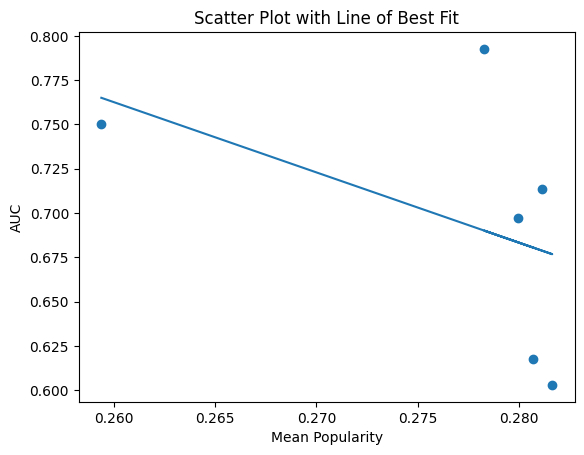

In [ ]:
# prompt: using dataset_mean_popularity and auc_for_datasets which are dictionaries for of dataset strings to numbers I want to create a scatter graph with a line of best fit
DATASETS = ['original', '53081', '51881', '42731', '41401', '25000']#'5990'teams, '5849', '4280', '4019', '2724']

import matplotlib.pyplot as plt
import numpy as np

mean_pop = [dataset_z_outliers[dataset][0] for dataset in DATASETS]
mean_auc = [auc_for_datasets[dataset] for dataset in DATASETS]

# Create the scatter plot
plt.scatter(mean_pop, mean_auc)

# Calculate the line of best fit
x = np.array(mean_pop)
y = np.array(mean_auc)
m, b = np.polyfit(x, y, 1)

# Plot the line of best fit
plt.plot(x, m*x + b)

# Set the labels and title
plt.xlabel("Mean Popularity")
plt.ylabel("AUC")
plt.title("Scatter Plot with Line of Best Fit")

# Show the plot
plt.show()


In [12]:
'''
Output a results file as json and csv
'''
results_file = os.path.join(sample_size_dir, 'program_data', 'results_random_forest_diff_amounts.pkl') #uuid for the left padding and truncation 775573dc-4e77-4529-92da-26710502ad50.pkl')

if not os.path.exists(results_file):
  save_results({}, results_file)

results = load_results(results_file)

print(json.dumps(results, indent=2))

csv = []
for dataset, dataset_res in results.items():
  for model, model_results in dataset_res.items():
    print()
    print()
    print('Model, %s' % model)
    print('Dataset, %s' % dataset)
    metrics_printed = False
    for sample_size in sorted(model_results.keys()):
      sample_size_results = model_results[sample_size]
      if not metrics_printed:
        print(','.join(['sample size'] + sorted(sample_size_results.keys())))
        metrics_printed= True
      print(str(sample_size) + ',', end='')
      for metric in sorted(sample_size_results.keys()):
        metric_results = str(sum(sample_size_results[metric]) / len(sample_size_results[metric]))
        print(metric_results + ',', end='')
      print()


Streaming output truncated to the last 5000 lines.
          0.7083333134651184
        ],
        "mccs": [
          0.43500059843063354,
          0.438846230506897,
          0.4188228249549866,
          0.41333332657814026,
          0.46020713448524475,
          0.4650006592273712,
          0.4200023412704468,
          0.4484734833240509,
          0.4467287063598633,
          0.4233427345752716
        ],
        "gmeans": [
          0.7174994874571002,
          0.7187605065448597,
          0.7087547855002589,
          0.7066666483879089,
          0.7298458630909563,
          0.7324995426665505,
          0.7099980223617715,
          0.7240587705306584,
          0.7232853240450998,
          0.7116588371901098
        ]
      },
      "7560": {
        "accuracy": [
          0.7275000214576721,
          0.7316666841506958,
          0.7283333539962769,
          0.7141666412353516,
          0.7333333492279053,
          0.7350000143051147,
          0.71083331108